In [713]:
import torch
import torch.nn.functional as F

In [734]:
# SETUP CONSTANTS

from util import get_names, PAD, ctoi, itoc, N_CHARS

CONTEXT: int = 7
EMBEDDING_WIDTH: int = 2
HIDDEN_WIDTH: int = 100
BATCH_SIZE: int = 32
DEVICE = 'cpu'
# DEVICE = 'mps'
# DEVICE = 'cuda'

names = get_names()

# PREP DATA

def get_xs_and_ys():
    padding = PAD * CONTEXT # e.g. '.....'
    n = CONTEXT + 1

    xlist: list[list[int]] = []
    ylist: list[int] = []

    for name in names:
        name = padding + name + padding
        sets = [list(name[i:i+n]) for i in range(len(name) - n * 2 + 3)]
        for set in sets:
            xlist.append([ctoi[c] for c in set[:-1]])
            ylist.append(ctoi[set[-1]])

    xs = torch.tensor(xlist, dtype=torch.int64).to(device=DEVICE)
    # xs = F.one_hot(xs, N_CHARS).float()
    ys = torch.tensor(ylist, dtype=torch.int64).to(device=DEVICE)

    return (xs, ys)

xs, ys = get_xs_and_ys()

split = int(xs.shape[0] * 0.5)
xs_test = xs[split:]
ys_test = ys[split:]
xs = xs[:split]
ys = ys[:split]

print(f"xs.shape: {xs.shape}")
# print(ys.shape)
# print(xs_test.shape)
# print(ys_test.shape)

M = ys.shape[0]

# INITIALIZE MODEL

EmbeddingMatrix = torch.randn(N_CHARS, EMBEDDING_WIDTH).to(device=DEVICE) # will be ran once for each context character
# The output is concatenated along the embedding dim before passing to the hidden layer
# print(EmbeddingMatrix.shape)

W1 = torch.randn([CONTEXT * EMBEDDING_WIDTH, HIDDEN_WIDTH]).to(device=DEVICE) * 0.01
B1 = torch.randn([1, HIDDEN_WIDTH]).to(device=DEVICE) * 0.0
BN1_gain = torch.ones([1, HIDDEN_WIDTH])
BN1_bias = torch.zeros([1, HIDDEN_WIDTH])
BN1_mean = torch.zeros([1, HIDDEN_WIDTH])
BN1_std = torch.ones([1, HIDDEN_WIDTH])

W2 = torch.randn([HIDDEN_WIDTH, N_CHARS]).to(device=DEVICE) * 0.01
B2 = torch.randn([1, N_CHARS]).to(device=DEVICE) * 0.0

params = [EmbeddingMatrix, W1, B1, W2, B2, BN1_gain, BN1_bias]

for p in params:
    p.requires_grad = True
    
param_count = sum([param.numel() for param in params])
print(f"param count: {param_count}")

losses = []

name count: 6782
xs.shape: torch.Size([23494, 7])
param count: 4481


In [744]:
for _ in range(2000):
    mb_is = torch.randint(0, M, [BATCH_SIZE])
    mb_xs = xs[mb_is]
    mb_ys = ys[mb_is]

    # FORWARD
    # TODO: Eliminate cat by using multidimentional indexing and view instead. Building Makemore pt. 2 @ 16:30
    embeddings = EmbeddingMatrix[mb_xs].view(mb_xs.shape[0], CONTEXT * EMBEDDING_WIDTH)
    h_out = embeddings @ W1 + B1
    b_mean = h_out.mean(0, keepdim=True)
    b_std = h_out.std(0, keepdim=True)
    BN1_mean = 0.999 * BN1_mean + 0.001 * b_mean
    BN1_std = 0.999 * BN1_std + 0.001 * b_std
    h_norm = BN1_gain * (h_out - b_mean) / b_std + BN1_bias
    h_activations = torch.tanh(h_norm)
    logits = h_activations @ W2 + B2

    loss = F.cross_entropy(logits, mb_ys)
    losses.append(loss.item())
    # print(loss.item())

    # LOSS
    # counts = logits.exp()
    # prob = counts / counts.sum(dim=1, keepdim=True)
    # loss = - prob[torch.arange(M, dtype=torch.int64), ys].log().mean()
    # print(loss)

    # BACKWARD
    for p in params:
        p.grad = None
    loss.backward()

    # STEP
    for p in params:
        p.data += -0.01* p.grad # type: ignore

print(f"Train Loss: {losses[-1]:.4}")

embeddings = EmbeddingMatrix[xs_test].view(xs_test.shape[0], CONTEXT * EMBEDDING_WIDTH)
h_out = embeddings @ W1 + B1
h_norm = BN1_gain * (h_out - BN1_mean) / BN1_std + BN1_bias
h_activations = torch.tanh(h_norm)
logits = h_activations @ W2 + B2
test_loss = F.cross_entropy(logits, ys_test)

print(f"Test Loss: {test_loss.item():.4}")

Train Loss: 1.876
Test Loss: 2.4


In [745]:
# Predict

for i in range(25):
    name = PAD * CONTEXT

    while name[-1] != PAD or len(name) == CONTEXT:
        _xs = torch.tensor([ctoi[c] for c in name[-CONTEXT:]]).unsqueeze(dim=0)
        # print(xs.shape)

        embeddings = EmbeddingMatrix[_xs].view(_xs.shape[0], CONTEXT * EMBEDDING_WIDTH)
        h_out = embeddings @ W1 + B1
        h_norm = BN1_gain * (h_out - BN1_mean) / BN1_std + BN1_bias
        h_activations = torch.tanh(h_norm)
        logits = h_activations @ W2 + B2

        probs = F.softmax(logits)

        i = int(torch.multinomial(probs, 1, replacement=True).item())

        name += itoc[i]

    name = name.strip('.')
    print(name)

kolteg
bonorteare
jemrie
binhon
hirbe

tevaon
rfinyq
anthmeof
lalon
shalrer
rardino
erylen
avizm
therd
jrulald
kostyv
lementao
cetnanh
rade
ebcer
padent
shaioi
feraud
aq


/var/folders/2k/g9g7tsv17yz6bznx2ws2v5940000gn/T/ipykernel_5841/1274181474.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(logits)


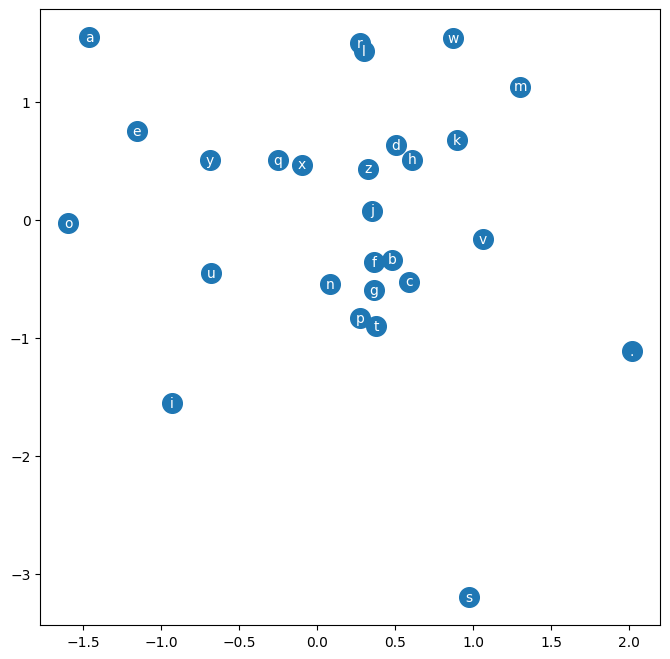

In [748]:
import matplotlib.pyplot as plt

C = EmbeddingMatrix

plt.figure(figsize=(8, 8))
cmap = 'inferno' # 'viridis' 'rainbow'
s = 200
x = C[:, 0].data.cpu()
y = C[:, 1].data.cpu() if EMBEDDING_WIDTH > 1 else torch.tensor([0 for _ in range(N_CHARS)])

if EMBEDDING_WIDTH > 2:
    z = C[:, 2].data.cpu()
    plt.scatter(x, y, s=200, c=z) # rainbow
else:
    plt.scatter(x, y, s=s)

for i in range(N_CHARS):
    plt.text(x[i].item(), y[i].item(), itoc[i], ha="center", va="center", color="white")
# plt.grid('minor')